<img src="../../Img/backdrop-wh.png" alt="Drawing" style="width: 300px;"/>

DIGHUM160 - Critical Digital Humanities<br>
Digital Hermeneutics<br>
Week 5-1: Naive Bayes Classification<br>
Created by Tom van Nuenen (tom.van_nuenen@kcl.ac.uk)

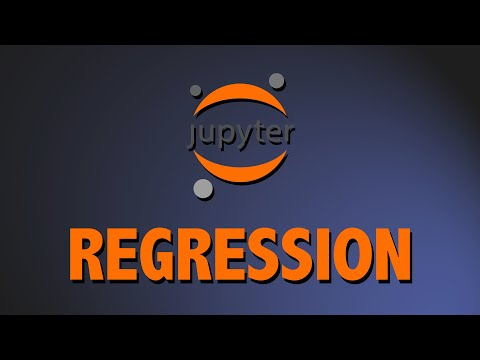

In [57]:
# Please run this cell for the accompanying video.
from IPython.display import YouTubeVideo
YouTubeVideo('lSUA40VR3LY', width=640, height=360)

#  Naive Bayes Classification

This notebook introduces Naive Bayes Classifiers to differentiate between different "classes" of data. 

A Naive Bayes classifier is a machine learning algorithm that uses **Bayes’ Theorem** to predict the class that a sample belongs to, given a number of features that describe that sample. It is based on the concept of conditional probability: “What is the probability of our X, given Y?”. Which in our case is: "What is the probability of a post belonging to a category, given its word frequencies?" The math behind Bayes' Theorem is simple but intuitive. For more info, check out [this post](http://www.dealingdata.net/2016/07/24/PoGo-Series-NaiveBayesClassifier/).

Naive Bayes classifiers are often considered the baseline for classification tasks. They have worked quite well in many real-world situations, famously document classification and spam filtering. Mathematically speaking, they are very straightforward, you can use them when you have limited resources in terms of CPU and memory. Further, when the training time is a crucial factor, Naive Bayes comes handy since it can be trained very quickly. 

One peculiar aspect of Naive Bayes classifiers is that they assume that the features you use are *conditionally independent*: knowledge of the outcome of one feature does not grant us knowledge of the outcome of any other feature. When dealing with text, this means that we’re not looking at entire sentences, but rather at individual words in a Bag-of-Words model. So “this was a fun party” is treated the same as “was this a fun party” and “party fun was this”.

This is a pretty naive assumption (separate features are often correlated) — hence the name Naive Bayes Classifier. Yet, it turns out the algorithm often performs just as well than much more complex machine learning models.

In [1]:
# sklearn
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction import text
stop = text.ENGLISH_STOP_WORDS

# General data science
import numpy as np
import re
import pandas as pd
import collections
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
from IPython.display import clear_output

## Test using 20 Newsgroups

The 20 newsgroups dataset consists of around 18000 newsgroups posts on 20 topics. It's helpfully split in two subsets: one for training (i.e. development), and one for testing (i.e. performance evaluation). 

We will use a Naive Bayes classifier to **predict the topics of the posts in our test set**, based on the **word frequencies** in the posts in our training set. 

First, let's get the data. The `.target_names` method yields the topics that the newsgroups have been classified in.

In [2]:
data = fetch_20newsgroups()

In [3]:
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Let's just get four of those to do our test with. We create a **training set** and a **test set**. The training set is, as the name implies, to train our classifier on. The test set we use to evaluate the performance of that classifier.

In [4]:
categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

What does the data look like?


In [5]:
test.data[5]

"From: jsledd@ssdc.sas.upenn.edu (James Sledd)\nSubject: Re: Dreams and out of body incidents\nOrganization: Social Science Computing\nLines: 6\n\nIn article <May.14.02.10.02.1993.25119@athos.rutgers.edu> alisonjw@spider.co.uk (Alison J Wyld) writes:\n>From: alisonjw@spider.co.uk (Alison J Wyld)\n>PS. Just to make it clear, I don't do ( and have never tried ) OOBEs.\n>    I tend to think they are off limits for Christians.\n\nWHY?\n"

To convert the content of each string into a vector of numbers, we will use Scikit-learn's `TfidfVectorizer()` method again.

We're using sklearn's `MultinomialNB` as our classifier. **Multinomial Naive Bayes** is a specialized version of Naive Bayes that is specifically designed for text documents. Whereas *Simple Naive Bayes* would model a document as the presence and absence of particular words, *Multinomial Naive Bayes* explicitly models all the word counts and adjusts the underlying calculations. For more on the difference between these classifiers, see:
http://blog.datumbox.com/machine-learning-tutorial-the-naive-bayes-text-classifier/ 

Scikit-klearn allows us to create a **pipeline** using `make_pipeline()`, which attaches this vectorizer to a multinomial naive Bayes classifier (meaning we don't have to instantiate these methods separately).

In [6]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

### Fitting the data

With this pipeline, we can apply the model to the training data, and then predict labels for the test data:

In [7]:
model.fit(train.data, train.target)
labels = model.predict(test.data)

In [8]:
labels[:5]

array([2, 0, 1, 0, 1])

Now that we have predicted the labels for the test data, we can evaluate them to learn about the performance of the estimator. For example, here is the confusion matrix between the true and predicted labels for the test data:

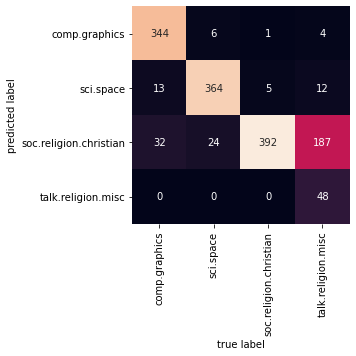

In [9]:
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Evidently, even this very simple classifier based on tf-idf scores can successfully separate posts about space from posts about computers. It gets confused, however, between talk about religion and talk about Christianity – an expected area of confusion.


### Prediction
With this classifier, we can now determine the category for any string, using the `predict()` method of this pipeline. Let's write a utility function that will return the prediction for a single string:

In [44]:
def predict_category(s, train=train, model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]

In [11]:
predict_category('Scientists discover new moon around Saturn')

'sci.space'

It works!

**Remember:** this is nothing more than a simple probability model for the (weighted) frequency of each word in the string! Nevertheless, the result is striking. Even a very naive algorithm, when used carefully and trained on a large set of high-dimensional data, can be surprisingly effective.

## Classification on r/amitheasshole

We will now use the same technique on a subreddit. We'll be using the subreddit r/amitheasshole: a subreddit in which members can vote whether an original poster [OP], in some social interaction, behaved like, you gueeded in, an asshole.

### Preprocessing

We'll start by cleaning up our data a bit. Let's load it up.

In [12]:
import os
# We include two ../ because we want to go two levels up in the file structure
os.chdir("../../Data")

In [13]:
import pandas as pd 

# importing file in df
df = pd.read_csv('aita_sub_top_sm_lemmas.csv')

### A classifier for assholes?

Now that we've seen how classification works, let's write a classifier for this subreddit. A typical use of this would be, for instance, to classify which particular subreddit a post belongs to. Or to classify posts that should be categorized as "NSFW".

But you can also use classification to test out certain hypotheses: for instance, can we predict whether a post will be classified as "ITA" (*Is The Asshole*), given its textual features?

Luckily, the members of r/amitheasshole have done some work for us by labeling the posts. We can use these labels to train our classifier. Let's have a look at the `flair_css_class` column in our DataFrame.

In [14]:
df['flair_css_class'].value_counts()

not         10995
ass          3906
1               2
shitpost        1
Name: flair_css_class, dtype: int64

Looks like the `flair_css_class` column contains lots of tags for asshole and non-asshole posts. Let's use this column for now. We'll remove anything that's *not* classified as `not` or `ass`.

In [15]:
df = df[~df['flair_css_class'].isin(['shitpost', '1' ])].dropna(subset=['flair_css_class'])
len(df)

14901

The next issue is that we have an unbalanced classification: "Not the Asshole" (`not`) posts occur over double as many times as "Asshole" (`ass`). This is in itself interesting! 

We can choose to either **upsample** our "Asshole" category (by adding doubles) or **downsampling** our "Not the A-hole" category by removing entries. You ideally have to try both, as what works best differs from case to case, but let's downsample for now. 

First, we want our DataFrame sorted. Then, we create a boolean mask for the negative values, use `np.where` to get the indices of these rows, `drop` these indices, then drop one half of those indices:

In [16]:
# Sorting the values
df.sort_values('flair_css_class', inplace=True)

# creating a mask for the condition
mask = (df.flair_css_class == "not")

# find out which indexes this condition refers to using np.where()
idx, = np.where(mask)

# divide by 2 and drop the indices
df.drop(df.index[idx[:len(idx)//2]], inplace=True)

Let's see how many entries for our classes we have now.


In [17]:
df['flair_css_class'].value_counts()

not    5498
ass    3906
Name: flair_css_class, dtype: int64

Looks more balanced now!

Lemmatizing takes a long time, so we don't want to do it twice. We'll save the lemmatized list in a pickle, in case we need it later.

### Commence training

Now for the classfier! We'll first create our training and test set, using the lemmas as `X` and `flair_css_class` as `y`. So we're predicting `y` given `X`.

In [51]:
X = df['selftext']
y = df['flair_css_class']

Next, we split our data into training and test sets again. We can easily do this using scikit-learn's `train_test_split()` method. The method takes a parameter denoting the size of the test set (20% of the total set, in this case).

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Why are we splitting into training and testing sets before vectorizing?

If we vectorize *before* we train/test split, our doc-term matrix would contain every single feature (word) in the test and training sets. What we want is to simulate the real world, where our classifier needs to encounters words it has not seen before. This allows us to evaluate it better.

So here's what we're doing: 

- We create a `TfidfVectorizer` instance
- `vect.fit.transform(X_train)` learns the t-fidf vocabulary of the training data, and uses the fitted vocabulary to build a document-term matrix from the training data;
- `vect.transform(X_test)` uses the fitted vocabulary to build a document-term matrix from the testing data (and ignores tokens it hasn't seen before).

In [53]:
vect = TfidfVectorizer(max_df=1.0, max_features=None, min_df=1) # we can add ngram_range=(1, 2) to include N-grams

# learn training data vocabulary, then use it to create a document-term matrix
X_train_dtm = vect.fit_transform(X_train)

# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

<1881x31255 sparse matrix of type '<class 'numpy.float64'>'
	with 358599 stored elements in Compressed Sparse Row format>

Time to create the classifier:

In [54]:
nb = MultinomialNB()
%time nb.fit(X_train_dtm, y_train)

CPU times: user 25.9 ms, sys: 4.01 ms, total: 29.9 ms
Wall time: 87.7 ms


MultinomialNB()

That was quick! Let's see what it yields.

In [55]:
# Make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

# Calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.5699096225412015

Text(91.68, 0.5, 'predicted label')

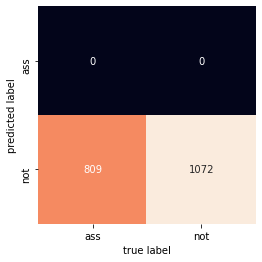

In [56]:
categories = ['ass', 'not']
mat = confusion_matrix(y_test, y_pred_class)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=categories, yticklabels=categories)
plt.xlabel('true label')
plt.ylabel('predicted label')

### Classification using logistic regression

As you can tell from the confusion matrix, our predictions are not particularly accurate. This is no surprise, as it would be quite a feat to predict this class based on word usage alone, especially for such a small dataset. If you'd want to pursue this hypothesis further, you could try to scale up the data, or take more features for X into account. 

Just for fun, let's try comparing this result to **logistic regression**, which is also often used for classification problems. Logistic regression tries to find the optimal decision boundary that best separates classes.

The difference between Naive Bayes and Logistic regression is that the first is a generative model, and the second a discriminative model. What does this mean?
- **Generative model**: Naive Bayes models the joint distribution of the feature X and target y, and then *predicts* the posterior probability given as P(y|X)
- **Discriminative model**: Logistic regression *directly models* the posterior probability of P(y|X) by learning the input to output mapping and minimizing the error.

Unlike Naive Bayes, logistic regression typically works reasonably well even when some of the features (in our case, words) are correlated. This is why it can be a good idea to try both when dealing with texts (because certain words *do* tend to appear in each other's vicinity!).

In [24]:
# instantiate a logistic regression model
logreg = LogisticRegression()

In [25]:
# train the model using X_train_dtm
%time logreg.fit(X_train_dtm, y_train)

CPU times: user 1.79 s, sys: 645 ms, total: 2.44 s
Wall time: 465 ms


LogisticRegression()

In [26]:
# make class predictions for X_test_dtm
y_pred_class = logreg.predict(X_test_dtm)

In [27]:
# calculate predicted probabilities for X_test_dtm
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([0.68335401, 0.44103132, 0.46502454, ..., 0.628879  , 0.43548897,
       0.69160377])

In [28]:
# calculate accuracy
metrics.accuracy_score(y_test, y_pred_class)

0.6172248803827751

Still no good – but you get the idea.

### Improving the model

If you'd want to improve upon this model, you could try to extract other features from the text (for instance, based on the presence of certain words, sentence length, etc.). You could also start looking into other features from the metadata (e.g. the score it received) to improve the prediction – though this is beyond the scope of this notebook.

What you need to know is that this process is called **feature engineering**: taking whatever information you have about your problem and turning it into numbers that you can use to build your feature matrix.

Plugging other features into a classifier could potentially make it more accurate. For now, we can say that we cannot really tell the label based only on the words that people use in their posts.

### Finding the most distinctive terms

Before we move on, let's explore why we would want an accurate model in the first place! For one, this would allow us to calculate the approximate "assholishness" of each token.

In [29]:
# store the vocabulary of X_train
X_train_tokens = vect.get_feature_names_out()
len(X_train_tokens)

25673

In [30]:
# examine some tokens
print(X_train_tokens[100:150])

['13m' '13month' '13my' '13th' '13y' '13yo' '13yr' '14' '1400sq' '140lbs'
 '14ct' '14er' '14f' '14fbrother' '14i' '14m' '14th' '14y' '14yo' '14yrs'
 '15' '150' '15000it' '150k' '150kg' '150lbs' '1541087544754' '15am' '15f'
 '15h' '15ish' '15k' '15lbs' '15m' '15min' '15pound' '15th' '15year'
 '15yo' '16' '160k' '163cm' '165lbs' '1674217' '16acre' '16f' '16ish'
 '16k' '16m' '16mi']


Naive Bayes counts the number of times each token appears in each class. We can access the array of that count by running the `.feature_count_` method.


In [31]:
# note that the trailing underscore often acts to avoid naming errors
nb.feature_count_ 

array([[ 2.12162381,  6.16777836,  0.11496026, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.88330601, 10.76264468,  0.        , ...,  0.12255311,
         0.06022081,  0.1957391 ]])

What are we seeing here? The rows represent our classes (asshole / not an asshole), the columns represent our tokens (our total vocabulary).


In [32]:
# rows represent classes, columns represent tokens
nb.feature_count_.shape

(2, 25673)

In [33]:
# number of times each token appears across all ASS posts
ass_token_count = nb.feature_count_[0, :]
ass_token_count

array([2.12162381, 6.16777836, 0.11496026, ..., 0.        , 0.        ,
       0.        ])

In [34]:
# number of times each token appears across all NOT posts
not_token_count = nb.feature_count_[1, :]
not_token_count

array([ 3.88330601, 10.76264468,  0.        , ...,  0.12255311,
        0.06022081,  0.1957391 ])

We can now create a DataFrame of tokens with their separate ASS and NOT counts.

In [35]:
tokens = pd.DataFrame({'token':X_train_tokens, 'ass':ass_token_count, 'not':not_token_count}).set_index('token')
tokens[110:120] # just a random slice

,ass,not
token,,
14ct,0.000000,0.075014
14er,0.000000,0.195984
14f,2.143324,2.049230
14fbrother,0.000000,0.119085
14i,0.000000,0.115009
14m,0.000000,0.320997
14th,0.081493,0.410422
14y,0.244315,0.113001
14yo,1.109644,0.537994


Using `.class_count_`, we can count the number of observations in each class

In [36]:
# Naive Bayes counts the number of observations in each class
nb.class_count_

array([3142., 4381.])

In [37]:
# add 1 to 'ass' and 'not' counts to avoid dividing by 0
tokens['ass'] = tokens['ass'] + 1
tokens['not'] = tokens['not'] + 1
tokens.sample(5, random_state=6)

,ass,not
token,,
floral,1.289091,1.000000
legumessince,1.000000,1.106742
names,1.515527,1.000000
chabge,1.000000,1.257308
patience,2.377625,2.636335


In [38]:
# convert the 'ass' and 'not' counts into frequencies
tokens['ass'] = tokens['ass'] / nb.class_count_[0]
tokens['not'] = tokens['not'] / nb.class_count_[1]
tokens.sample(5, random_state=6)

,ass,not
token,,
floral,0.000410,0.000228
legumessince,0.000318,0.000253
names,0.000482,0.000228
chabge,0.000318,0.000287
patience,0.000757,0.000602


In [39]:
# calculate the ratio of ass-to-not for each token
tokens['ass_ratio'] = tokens['ass'] / tokens['not']
tokens.sample(5, random_state=6)

,ass,not,ass_ratio
token,,,
floral,0.000410,0.000228,1.797424
legumessince,0.000318,0.000253,1.259855
names,0.000482,0.000228,2.113152
chabge,0.000318,0.000287,1.108984
patience,0.000757,0.000602,1.257505


Finally, we can examine the DataFrame sorted by ass_ratio. These are the words, according to our classifier, that are the most typical of "assholeish" posts. A well-working classifier would yield interesting info here on how telling each word is for being considered an asshole by the community. But then again, creating such a classifier is not a trivial matter.  


In [40]:
# note: use sort() instead of sort_values() for pandas 0.16.2 and earlier
tokens.sort_values('ass_ratio', ascending=False)[:10]

,ass,not,ass_ratio
token,,,
taylor,0.001073,0.000228,4.702777
erin,0.000951,0.000228,4.166537
sabrina,0.000918,0.000228,4.023814
honk,0.001098,0.000290,3.791639
beth,0.001409,0.000385,3.661614
alyssa,0.000819,0.000228,3.589107
shrimp,0.001188,0.000349,3.402469
mikey,0.000756,0.000228,3.311161
harry,0.000750,0.000228,3.284590


In [41]:
# look up the not_ratio for a given token
tokens.loc['beard', 'ass_ratio']

1.2218982234162412

Looks like the word 'beard' occurs 3 as often for people who are classified as assholes (according to our very imprecise classifier at least). With a precise classifier, this would be a very interesting result!

### Looking at other classes

We've trained for 2 classes now (asshole and non-asshole), but the posts in this subreddit (as well as many others) actually have more labels, called **flair**. We can find them here under the `flair_text` category.

In [42]:
df.flair_text.unique()[:100]

array(['asshole', 'Asshole', 'Everyone Sucks', 'OP Banned - Rule 3',
       'Probably Fake', 'Probably a Fake Story',
       'Fake story/Everyone Sucks', 'asshole (Kinda)',
       'justified asshole', 'Asshole (maybe justified?)',
       'Record Setting Asshole', 'Not the A-hole', 'No A-holes here',
       'probably fake', 'not the a-hole', 'weeabo h8r', 'Pobably Fake'],
      dtype=object)

Quite a lot of categories, turns out. Let's see what the most-frequent categories are, as well as their counts:

In [43]:
df['flair_text'].value_counts()

Not the A-hole                5105
Asshole                       3246
Everyone Sucks                 646
No A-holes here                382
not the a-hole                   8
asshole                          4
Probably Fake                    3
Record Setting Asshole           1
weeabo h8r                       1
probably fake                    1
justified asshole                1
Asshole (maybe justified?)       1
asshole (Kinda)                  1
Fake story/Everyone Sucks        1
Probably a Fake Story            1
OP Banned - Rule 3               1
Pobably Fake                     1
Name: flair_text, dtype: int64

## What to do next

As you can see, there are a bunch of categories, particularly "Everyone Sucks" and "No A-holes here", which we could work with as well. The point is that as long as you can find categorical variables in your data, you can use them in a classification context. Learning to see these opportunities is part of becoming a data scientist. Of course, as we discussed in the notebooks on Word Embeddings and language bias, you will also realize that classification itself can be the problem.